## Exploratory Data Analysis on Interim Data

- Out of good ML principles, we'll only be looking at Arkansas, our training set.


In [49]:
try:
    sc.stop()
except:
    pass
from pyspark import SparkContext
from bigdl.util.common import *

# create sparkcontext with bigdl configuration
sc = SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[*]"))
from pyspark.sql import SparkSession
spark = SparkSession(sparkContext = sc)
spark.conf.set("spark.sql.session.timeZone", "UTC")

In [50]:
df = spark.read.csv(f"hdfs://localhost:9000/solar_data/interim/Arkansas_interim.csv", inferSchema=True, header=True)

In [51]:
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [5]:
#For debugging:
print(sns.__version__,'\n',scipy.__version__)

0.8.0 
 1.5.4


In [4]:
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Minute: integer (nullable = true)
 |-- Cloud Type: integer (nullable = true)
 |-- Dew Point: integer (nullable = true)
 |-- Fill Flag: integer (nullable = true)
 |-- Wind Speed: double (nullable = true)
 |-- Surface Albedo: double (nullable = true)
 |-- Temperature: integer (nullable = true)
 |-- Solar Zenith Angle: double (nullable = true)
 |-- Wind Direction: double (nullable = true)
 |-- GHI: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)



In [12]:
pd.__version__

'0.20.3'

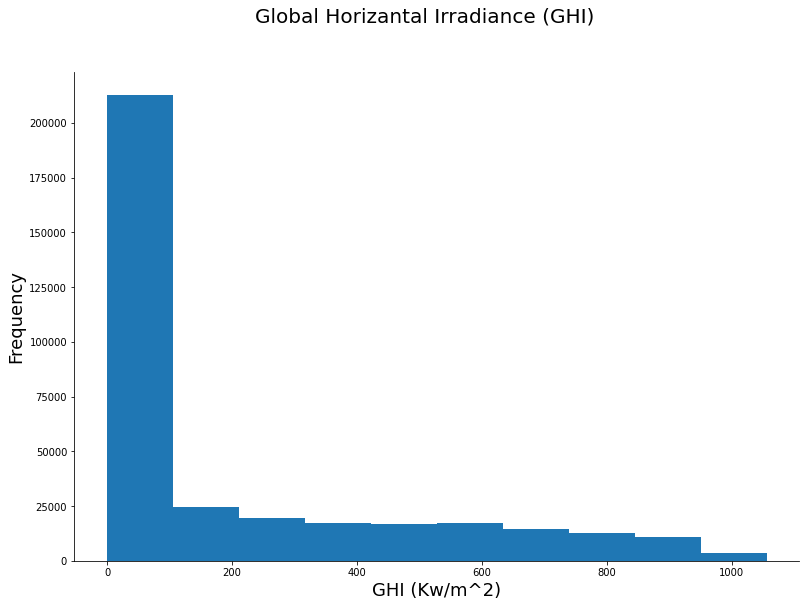

In [41]:
### Let's take a look at our target variable, Global Horizantal Irradiance (GHI)
ghi = df.select('GHI').toPandas().plot(kind='hist', figsize=(13, 9), legend=False)
plt.suptitle('Global Horizantal Irradiance (GHI)', fontsize=20)
plt.xlabel('GHI (Kw/m^2)', fontsize=18)
plt.ylabel("Frequency", fontsize=18)
sns.despine()
plt.show();

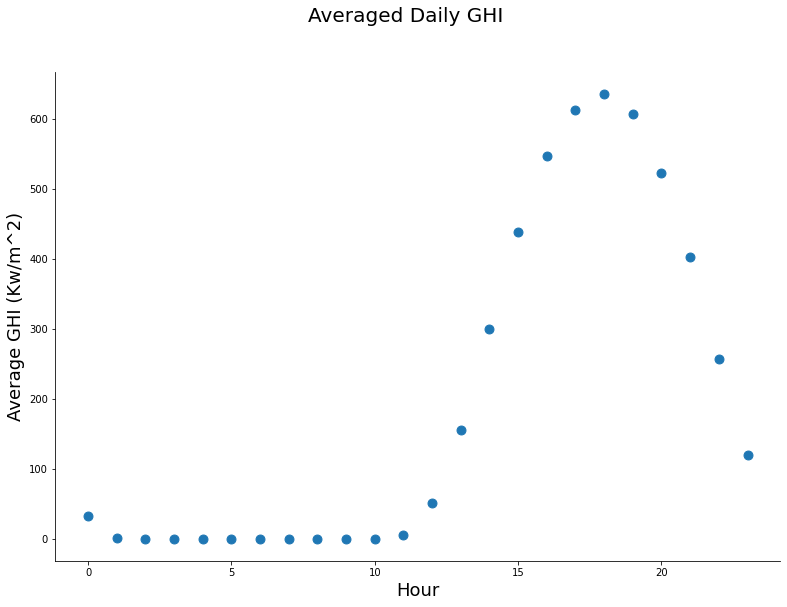

In [40]:
### Let's group by hour to see the day/night cycles
df.groupby('Hour').mean('GHI').toPandas().plot.scatter(x='Hour', y='avg(GHI)', figsize=(13, 9), s=80)
plt.suptitle('Averaged Daily GHI', fontsize=20)
plt.xlabel('Hour', fontsize=18)
plt.ylabel("Average GHI (Kw/m^2)", fontsize=18)
sns.despine()
plt.show();
#Interesting, It doesn't heat up until around 10am, and continues to heat past noon.

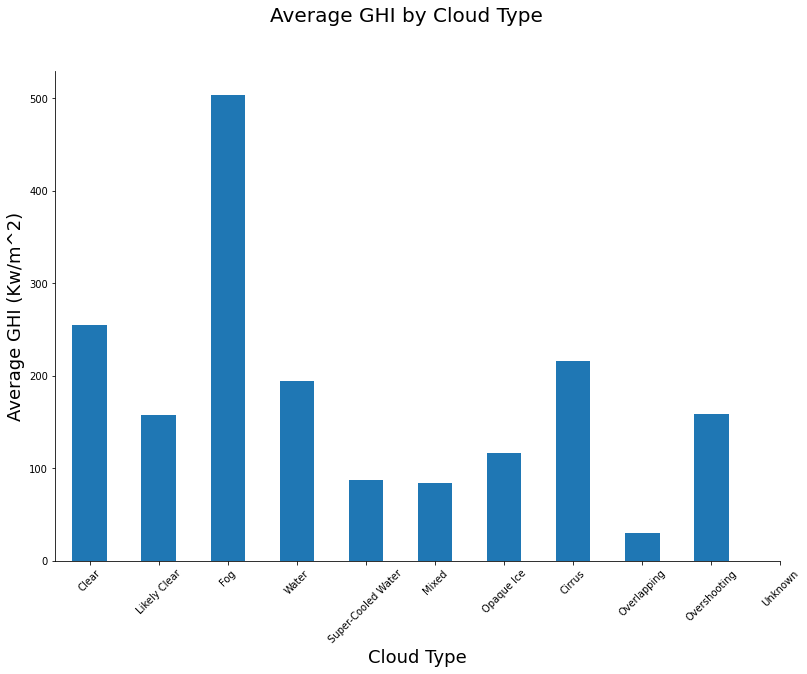

In [39]:
### How do the different cloud types effect GHI?
df.groupby('Cloud Type').mean('GHI').sort('Cloud Type').toPandas().plot.bar(figsize=(13, 9), x='Cloud Type', y='avg(GHI)', legend=False)
plt.suptitle('Average GHI by Cloud Type', fontsize=20)
plt.xlabel('Cloud Type', fontsize=18)
plt.ylabel("Average GHI (Kw/m^2)", fontsize=18)
labels = ['Clear', 'Likely Clear', 'Fog', 'Water', 'Super-Cooled Water', 'Mixed', 'Opaque Ice', 'Cirrus', 'Overlapping', 'Overshooting', 'Unknown']
plt.xticks(range(0, 11), labels, rotation = 45)
sns.despine()
plt.show();

##Interestingly, fog seems to amplify the GHI
#Even though the Direct Normal Irradiance (DNI) goes down, the Diffuse Horizontal Irradiance (DIF) likely
#Goes up do to the diffusion of the rays scattering in the low lying fog.
#Whether or not DIF is beneficial for solar panels is up for question given that solar arrays are usually
#set up to capture the Direct Normal Irradiance primarilly.

#GHI = DNI*DIF*cos(solar_zenith)


##Also note that overshooting clouds reduce the GHI the most.
#The Anvil shaped cloud top prevents the DNI contribution 
#And the height of the cloud from the ground prevents a significant diffusion (DIF) contribution

#The cirrus clouds also reduce the GHI more than expected. I would suspect that they reduce GHI less
#due to their thin, wispy nature.

### Cloud Type Meaning:

-15: NaN  
0: Clear   
1: Probably Clear 
2: Fog 
3: Water  
4: Super-Cooled Water 
5: Mixed 
6: Opaque Ice  
7: Cirrus  
8: Overlapping  
9: Overshooting  
10: Unknown 	 
11: Dust  
12: Smoke

In [33]:
from pyspark.sql.types import IntegerType

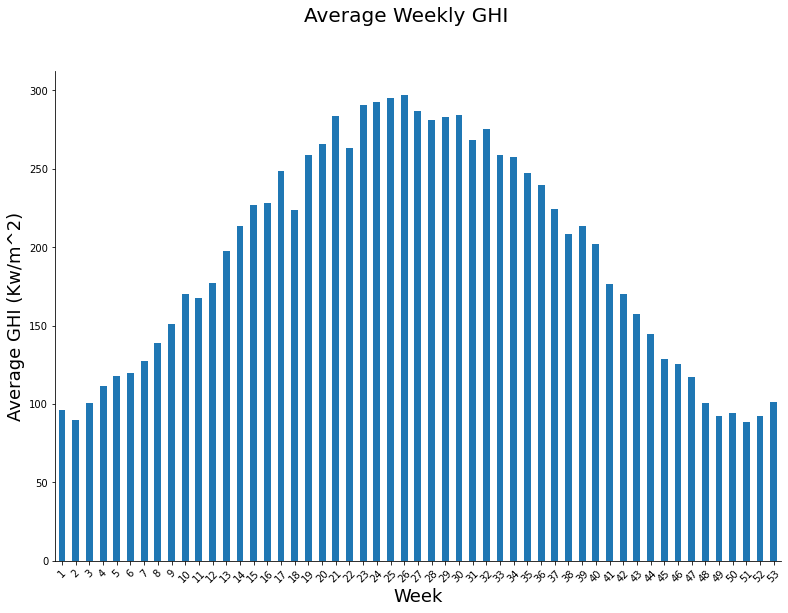

In [38]:
###Let's take a look at seasonal differences by observing the avg GHI by week
from pyspark.sql import functions as F

(df.withColumn('week', F.date_format(F.col('timestamp'), 'w'))
     .withColumn('week', F.col('week').cast(IntegerType()))
    .groupby('week').mean('GHI').sort(F.col('week').asc()).toPandas()
    .plot.bar(x='week', y='avg(GHI)', figsize=(13, 9), legend=False)
)
plt.suptitle('Average Weekly GHI', fontsize=20)
plt.xlabel('Week', fontsize=18)
plt.ylabel("Average GHI (Kw/m^2)", fontsize=18)
plt.xticks(rotation=45)
sns.despine()
plt.show();

##As expected, the highest avg(GHI) corresponds with the summer solstice, marking the longest day of the year
## the lowest avg(GHI) corresponds with the winter solstice, marking the shortest day of the year

<AxesSubplot:>

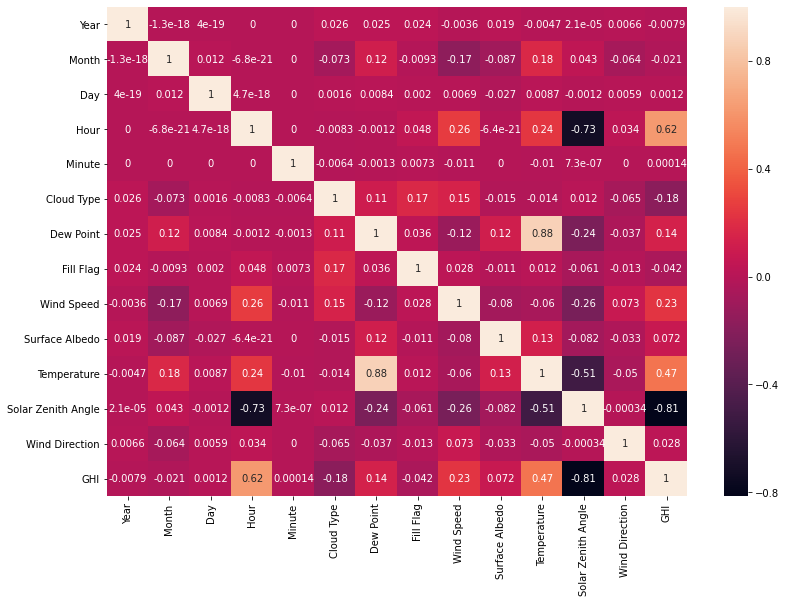

In [44]:
### Correlation Analysis

corrs = df.toPandas().corr()
plt.figure(figsize=(13, 9))
sns.heatmap(corrs, annot=True)

##Dew point and Temperature are potentially multicollinear:
    #this will be a problem for my base linear regression model
    #it may also effect the convergence of my LSTM
    #however MLPs are typically more robust to multicollinearity due to overparameterization
    #will test dropping temp or dewpoint or no columns while training.
    
#some of these features don't make sense to be analysed in this fashion, such as cloud type and fill flag

#The high negative correlation b/t GHI and zenith angle makes sense.
#the larger the zenith angle, the closer to the horizon the sun appears, and thus the more athmosphere the sun's rays
#have to pass through before reaching the surface, increasing scattering and thus decreasing GHI

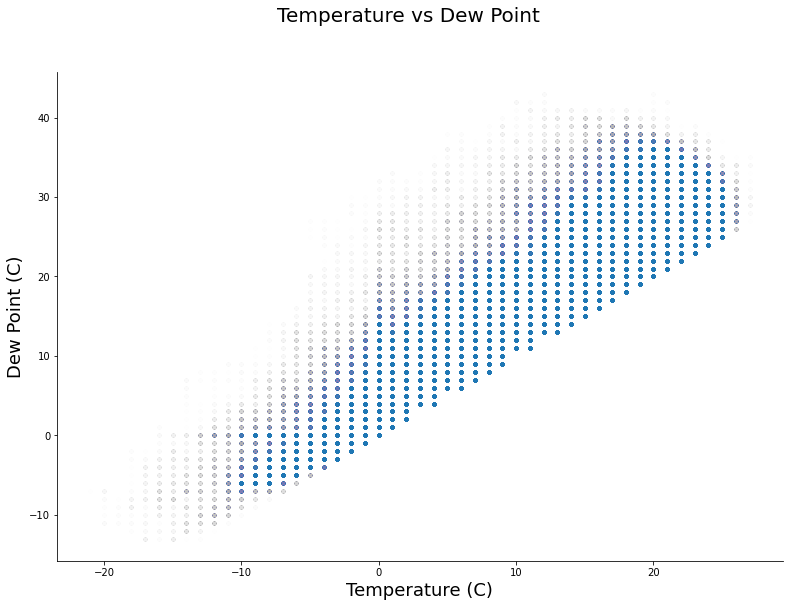

In [52]:
df.select('Dew Point', 'Temperature').toPandas().plot.scatter(x='Dew Point', y='Temperature', alpha=.005, figsize=(13, 9))
plt.suptitle('Temperature vs Dew Point', fontsize=20)
plt.xlabel('Temperature (C)', fontsize=18)
plt.ylabel("Dew Point (C)", fontsize=18)
sns.despine()
plt.show();
#Definitely a strong relationship, as temperature increases, dew point increases.
#Check perfomance of the feature by running ANOVA on regression (just statsmodel) (look for lower value)

In [47]:
## Hypothesis testing for Normality of features
# D'Agostino and Pearson's normality test
# H0: the sample comes from a normal distribution
# Ha: the sample does not come from a normal distribution

from scipy.stats import normaltest
cols = df.columns
for col in cols:
    #Siginificance level = .05
    _, p_val = normaltest(df.select(col).toPandas())
    if p_val < .05:
        print(f"{col} -- H0 rejected, is not normal")
    else:
        print(f"{col} -- Failed to reject H0, is normal.")
#will have to normalize my features before feeding into a linear regression model using the Box-Cox transformation

Year -- H0 rejected, is not normal
Month -- H0 rejected, is not normal
Day -- H0 rejected, is not normal
Hour -- H0 rejected, is not normal
Minute -- H0 rejected, is not normal
Cloud Type -- H0 rejected, is not normal
Dew Point -- H0 rejected, is not normal
Fill Flag -- H0 rejected, is not normal
Wind Speed -- H0 rejected, is not normal
Surface Albedo -- H0 rejected, is not normal
Temperature -- H0 rejected, is not normal
Solar Zenith Angle -- H0 rejected, is not normal
Wind Direction -- H0 rejected, is not normal
GHI -- H0 rejected, is not normal


UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')